# ECM Forecasting Performance Evaluation

This notebook evaluates the out-of-sample forecasting performance of the Error Correction Model (ECM) for beef prices.

**Approach:**
- Train ECM on first 200 observations
- Test on remaining observations
- Assumes cointegration between beef and poultry prices (established in main ECM notebook)
- No need to re-run stationarity tests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_style('whitegrid')

## 1. Load and Split Data

Load both levels (for long-run relationship) and first-differenced data (for ECM), then split into train/test sets.

In [2]:
# Load clean data (in levels)
df_clean = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

# Drop D0_USA to avoid multicollinearity
df_clean = df_clean.drop(columns=['D0_USA'])

# Load first differenced data
df_firstdiff = pd.read_csv('../data/df_firstdiff.csv', index_col=0, parse_dates=True)

# Drop D0_USA to avoid multicollinearity
df_firstdiff = df_firstdiff.drop(columns=['D0_USA'])

print("="*100)
print("DATA LOADED")
print("="*100)
print(f"\nClean data (levels): {df_clean.shape}")
print(f"First-differenced data: {df_firstdiff.shape}")
print(f"\nDate range: {df_clean.index.min()} to {df_clean.index.max()}")

DATA LOADED

Clean data (levels): (242, 17)
First-differenced data: (241, 17)

Date range: 2002-11-01 00:00:00 to 2022-12-01 00:00:00


In [3]:
# Train-test split
n_train = 200

# Split levels data
df_clean_train = df_clean.iloc[:n_train]
df_clean_test = df_clean.iloc[n_train:]

# Split first-differenced data
df_firstdiff_train = df_firstdiff.iloc[:n_train]
df_firstdiff_test = df_firstdiff.iloc[n_train:]

print("\n" + "="*100)
print("TRAIN-TEST SPLIT")
print("="*100)
print(f"\nTraining set:")
print(f"  - Levels data: {df_clean_train.shape[0]} observations | {df_clean_train.index[0]} to {df_clean_train.index[-1]}")
print(f"  - Differenced data: {df_firstdiff_train.shape[0]} observations | {df_firstdiff_train.index[0]} to {df_firstdiff_train.index[-1]}")

print(f"\nTest set:")
print(f"  - Levels data: {df_clean_test.shape[0]} observations | {df_clean_test.index[0]} to {df_clean_test.index[-1]}")
print(f"  - Differenced data: {df_firstdiff_test.shape[0]} observations | {df_firstdiff_test.index[0]} to {df_firstdiff_test.index[-1]}")


TRAIN-TEST SPLIT

Training set:
  - Levels data: 200 observations | 2002-11-01 00:00:00 to 2019-06-01 00:00:00
  - Differenced data: 200 observations | 2002-12-01 00:00:00 to 2019-07-01 00:00:00

Test set:
  - Levels data: 42 observations | 2019-07-01 00:00:00 to 2022-12-01 00:00:00
  - Differenced data: 41 observations | 2019-08-01 00:00:00 to 2022-12-01 00:00:00


## 2. Estimate Long-Run Relationship (Training Set)

Estimate the cointegrating relationship between beef and poultry prices using only the training data.

In [4]:
# Estimate long-run relationship on training set
y_longrun = df_clean_train['PBEEFUSDM']
X_longrun = df_clean_train['PPOULTUSDM']
X_lr = sm.add_constant(X_longrun)

model_longrun = OLS(y_longrun, X_lr).fit()

print("\n" + "="*100)
print("STEP 1: LONG-RUN COINTEGRATING RELATIONSHIP (TRAINING SET)")
print("="*100)
print(f"\nBPEEFUSDM = {model_longrun.params['const']:.4f} + {model_longrun.params['PPOULTUSDM']:.4f} × PPOULTUSDM")
print(f"\nR-squared: {model_longrun.rsquared:.4f}")
print(f"Observations: {len(y_longrun)}")

# Extract coefficients
alpha = model_longrun.params['const']
beta = model_longrun.params['PPOULTUSDM']

# Calculate equilibrium errors for TRAINING SET
equilibrium_error_train = model_longrun.resid
print(f"\nEquilibrium error calculated for training period")


STEP 1: LONG-RUN COINTEGRATING RELATIONSHIP (TRAINING SET)

BPEEFUSDM = 6.8242 + 1.5769 × PPOULTUSDM

R-squared: 0.6429
Observations: 200

Equilibrium error calculated for training period


## 3. Estimate ECM (Training Set)

Estimate the Error Correction Model using the training data, incorporating the lagged equilibrium error from Step 1.

In [5]:
# Prepare ECM variables (training set)
y_ecm_train = df_firstdiff_train['PBEEFUSDM']

# Lagged equilibrium error
u_lag_train = equilibrium_error_train.shift(1)
u_lag_train.name = 'u_hat_lag1'

# Short-run variables (based on main ECM notebook specification)
shortrun_vars = [
    'PPOULTUSDM',
    'PLAMBUSDM',
    'PPORKUSDM',
    'POILBREUSDM',
    'fao_food_index',
    'retail_china',
    'fnbretail_USA',
    'bioethanol_production',
    'D1_USA',
    'D2_USA',
    'D3_USA',
    'D4_USA',
    'precip_BR',
    'enso_anomaly'
]

# Lagged dependent variable
beef_lag1_train = df_firstdiff_train['PBEEFUSDM'].shift(1)
beef_lag1_train.name = 'PBEEFUSDM_lag1'

# Combine all regressors
X_ecm_components = [u_lag_train] + [df_firstdiff_train[var] for var in shortrun_vars] + [beef_lag1_train]
X_ecm_train = pd.concat(X_ecm_components, axis=1)
X_ecm_train = sm.add_constant(X_ecm_train)

# Align and clean
data_ecm_train = pd.concat([y_ecm_train, X_ecm_train], axis=1).dropna()
y_ecm_train_clean = data_ecm_train.iloc[:, 0]
X_ecm_train_clean = data_ecm_train.iloc[:, 1:]

print("\n" + "="*100)
print("STEP 2: ERROR CORRECTION MODEL (TRAINING SET)")
print("="*100)
print(f"\nECM training sample: {len(y_ecm_train_clean)} observations")
print(f"Period: {data_ecm_train.index[0]} to {data_ecm_train.index[-1]}")
print(f"Number of regressors: {X_ecm_train_clean.shape[1]}")


STEP 2: ERROR CORRECTION MODEL (TRAINING SET)

ECM training sample: 198 observations
Period: 2003-01-01 00:00:00 to 2019-06-01 00:00:00
Number of regressors: 17


In [6]:
# Estimate ECM with HAC standard errors
maxlags_hac = int(4 * (len(y_ecm_train_clean) / 100) ** (2/9))
model_ecm = OLS(y_ecm_train_clean, X_ecm_train_clean).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags_hac})

print("\n" + "="*100)
print("ECM ESTIMATION RESULTS (HAC STANDARD ERRORS)")
print("="*100)
print(model_ecm.summary())

# Extract error correction coefficient
phi = model_ecm.params['u_hat_lag1']
print(f"\n✓ Error correction coefficient (φ): {phi:.6f}")
print(f"  p-value: {model_ecm.pvalues['u_hat_lag1']:.4f}")


ECM ESTIMATION RESULTS (HAC STANDARD ERRORS)
                            OLS Regression Results                            
Dep. Variable:              PBEEFUSDM   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     4.751
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           5.30e-08
Time:                        16:47:04   Log-Likelihood:                 362.43
No. Observations:                 198   AIC:                            -690.9
Df Residuals:                     181   BIC:                            -635.0
Df Model:                          16                                         
Covariance Type:                  HAC                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

## 4. Generate Forecasts for Test Set

Use the trained ECM to forecast beef price changes in the test period.

In [7]:
# Calculate equilibrium errors for the FULL SAMPLE (needed for test set forecasting)
# Using the long-run coefficients estimated from training set
equilibrium_error_full = df_clean['PBEEFUSDM'] - (alpha + beta * df_clean['PPOULTUSDM'])

print("\n" + "="*100)
print("GENERATING TEST SET FORECASTS")
print("="*100)

# Prepare test set features
y_ecm_test = df_firstdiff_test['PBEEFUSDM']

# Lagged equilibrium error for test set
u_lag_test = equilibrium_error_full.shift(1).loc[df_firstdiff_test.index]
u_lag_test.name = 'u_hat_lag1'

# Lagged dependent variable for test set
beef_lag1_test = df_firstdiff['PBEEFUSDM'].shift(1).loc[df_firstdiff_test.index]
beef_lag1_test.name = 'PBEEFUSDM_lag1'

# Combine test set regressors
X_ecm_test_components = [u_lag_test] + [df_firstdiff_test[var] for var in shortrun_vars] + [beef_lag1_test]
X_ecm_test = pd.concat(X_ecm_test_components, axis=1)
X_ecm_test = sm.add_constant(X_ecm_test)

# Align test data
data_ecm_test = pd.concat([y_ecm_test, X_ecm_test], axis=1).dropna()
y_ecm_test_clean = data_ecm_test.iloc[:, 0]
X_ecm_test_clean = data_ecm_test.iloc[:, 1:]

print(f"\nTest set observations: {len(y_ecm_test_clean)}")
print(f"Period: {data_ecm_test.index[0]} to {data_ecm_test.index[-1]}")

# Generate predictions
y_pred_test = model_ecm.predict(X_ecm_test_clean)

print(f"\n✓ Forecasts generated for {len(y_pred_test)} test observations")


GENERATING TEST SET FORECASTS

Test set observations: 41
Period: 2019-08-01 00:00:00 to 2022-12-01 00:00:00

✓ Forecasts generated for 41 test observations


## 5. Evaluate Forecast Performance

Calculate forecast accuracy metrics and compare predictions with actual values.

In [8]:
# Calculate forecast metrics
rmse = np.sqrt(mean_squared_error(y_ecm_test_clean, y_pred_test))
mae = mean_absolute_error(y_ecm_test_clean, y_pred_test)
r2 = r2_score(y_ecm_test_clean, y_pred_test)
mape = np.mean(np.abs((y_ecm_test_clean - y_pred_test) / y_ecm_test_clean)) * 100

# Calculate directional accuracy (sign prediction)
actual_direction = np.sign(y_ecm_test_clean)
pred_direction = np.sign(y_pred_test)
directional_accuracy = np.mean(actual_direction == pred_direction) * 100

print("\n" + "="*100)
print("FORECAST PERFORMANCE METRICS")
print("="*100)

print("\n📊 ERROR METRICS (Predicting Monthly Changes)")
print("-"*100)
print(f"RMSE (Root Mean Squared Error):  {rmse:.6f}")
print(f"MAE (Mean Absolute Error):        {mae:.6f}")
print(f"MAPE (Mean Absolute % Error):     {mape:.2f}%")
print(f"R² (Out-of-sample):               {r2:.4f}")

print("\n📈 DIRECTIONAL ACCURACY")
print("-"*100)
print(f"Correct direction predictions:    {directional_accuracy:.2f}%")
print(f"(Percentage of times model correctly predicts sign of price change)")

# Baseline comparison (naive forecast: no change)
naive_rmse = np.sqrt(mean_squared_error(y_ecm_test_clean, np.zeros(len(y_ecm_test_clean))))
naive_mae = mean_absolute_error(y_ecm_test_clean, np.zeros(len(y_ecm_test_clean)))

print("\n🎯 COMPARISON WITH NAIVE FORECAST (No Change Prediction)")
print("-"*100)
print(f"Naive RMSE:                       {naive_rmse:.6f}")
print(f"ECM RMSE:                         {rmse:.6f}")
print(f"RMSE Improvement:                 {((naive_rmse - rmse) / naive_rmse * 100):.2f}%")
print(f"\nNaive MAE:                        {naive_mae:.6f}")
print(f"ECM MAE:                          {mae:.6f}")
print(f"MAE Improvement:                  {((naive_mae - mae) / naive_mae * 100):.2f}%")


FORECAST PERFORMANCE METRICS

📊 ERROR METRICS (Predicting Monthly Changes)
----------------------------------------------------------------------------------------------------
RMSE (Root Mean Squared Error):  0.072266
MAE (Mean Absolute Error):        0.052875
MAPE (Mean Absolute % Error):     318.94%
R² (Out-of-sample):               -0.7888

📈 DIRECTIONAL ACCURACY
----------------------------------------------------------------------------------------------------
Correct direction predictions:    56.10%
(Percentage of times model correctly predicts sign of price change)

🎯 COMPARISON WITH NAIVE FORECAST (No Change Prediction)
----------------------------------------------------------------------------------------------------
Naive RMSE:                       0.054040
ECM RMSE:                         0.072266
RMSE Improvement:                 -33.73%

Naive MAE:                        0.035115
ECM MAE:                          0.052875
MAE Improvement:                  -50.58%


## 6. Visualize Forecast Performance

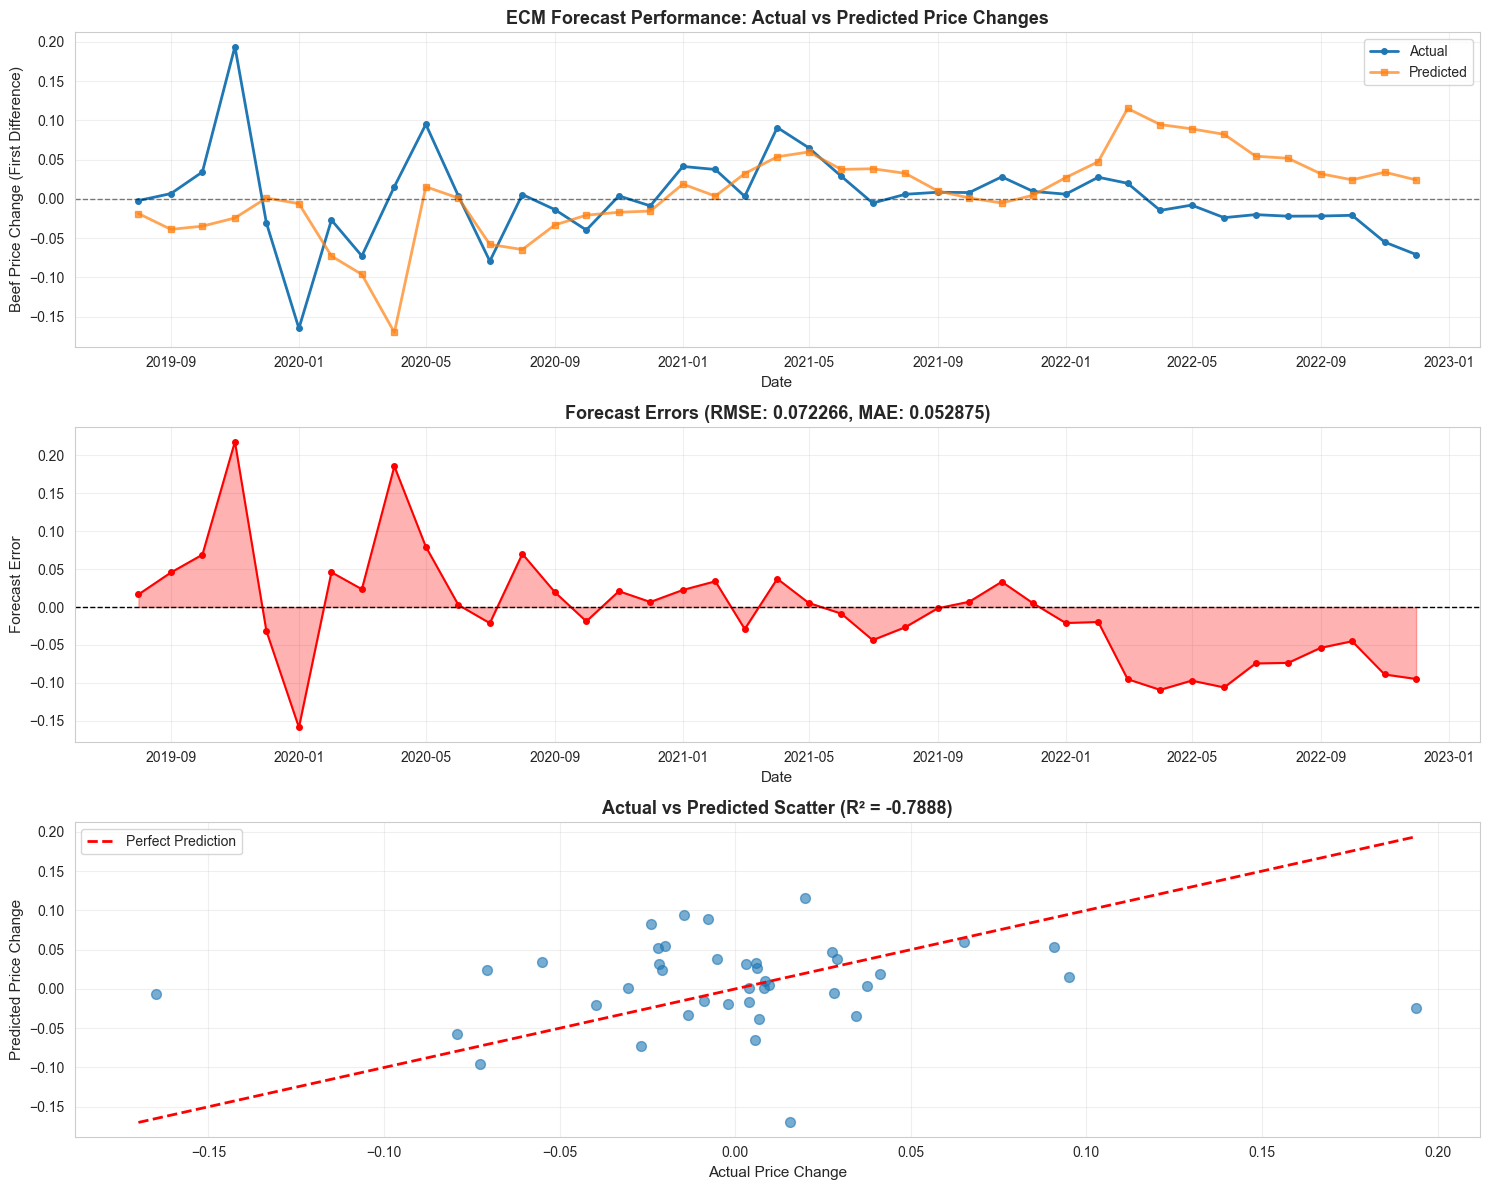

In [9]:
# Create comprehensive forecast visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Actual vs Predicted (Time Series)
ax1 = axes[0]
ax1.plot(y_ecm_test_clean.index, y_ecm_test_clean.values, 
         label='Actual', linewidth=2, marker='o', markersize=4)
ax1.plot(y_pred_test.index, y_pred_test.values, 
         label='Predicted', linewidth=2, marker='s', markersize=4, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Beef Price Change (First Difference)', fontsize=11)
ax1.set_title('ECM Forecast Performance: Actual vs Predicted Price Changes', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Forecast Errors
ax2 = axes[1]
errors = y_ecm_test_clean - y_pred_test
ax2.plot(errors.index, errors.values, color='red', linewidth=1.5, marker='o', markersize=4)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.fill_between(errors.index, errors.values, 0, alpha=0.3, color='red')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Forecast Error', fontsize=11)
ax2.set_title(f'Forecast Errors (RMSE: {rmse:.6f}, MAE: {mae:.6f})', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Actual vs Predicted (Scatter)
ax3 = axes[2]
ax3.scatter(y_ecm_test_clean, y_pred_test, alpha=0.6, s=50)
# 45-degree line
min_val = min(y_ecm_test_clean.min(), y_pred_test.min())
max_val = max(y_ecm_test_clean.max(), y_pred_test.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Price Change', fontsize=11)
ax3.set_ylabel('Predicted Price Change', fontsize=11)
ax3.set_title(f'Actual vs Predicted Scatter (R² = {r2:.4f})', 
              fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

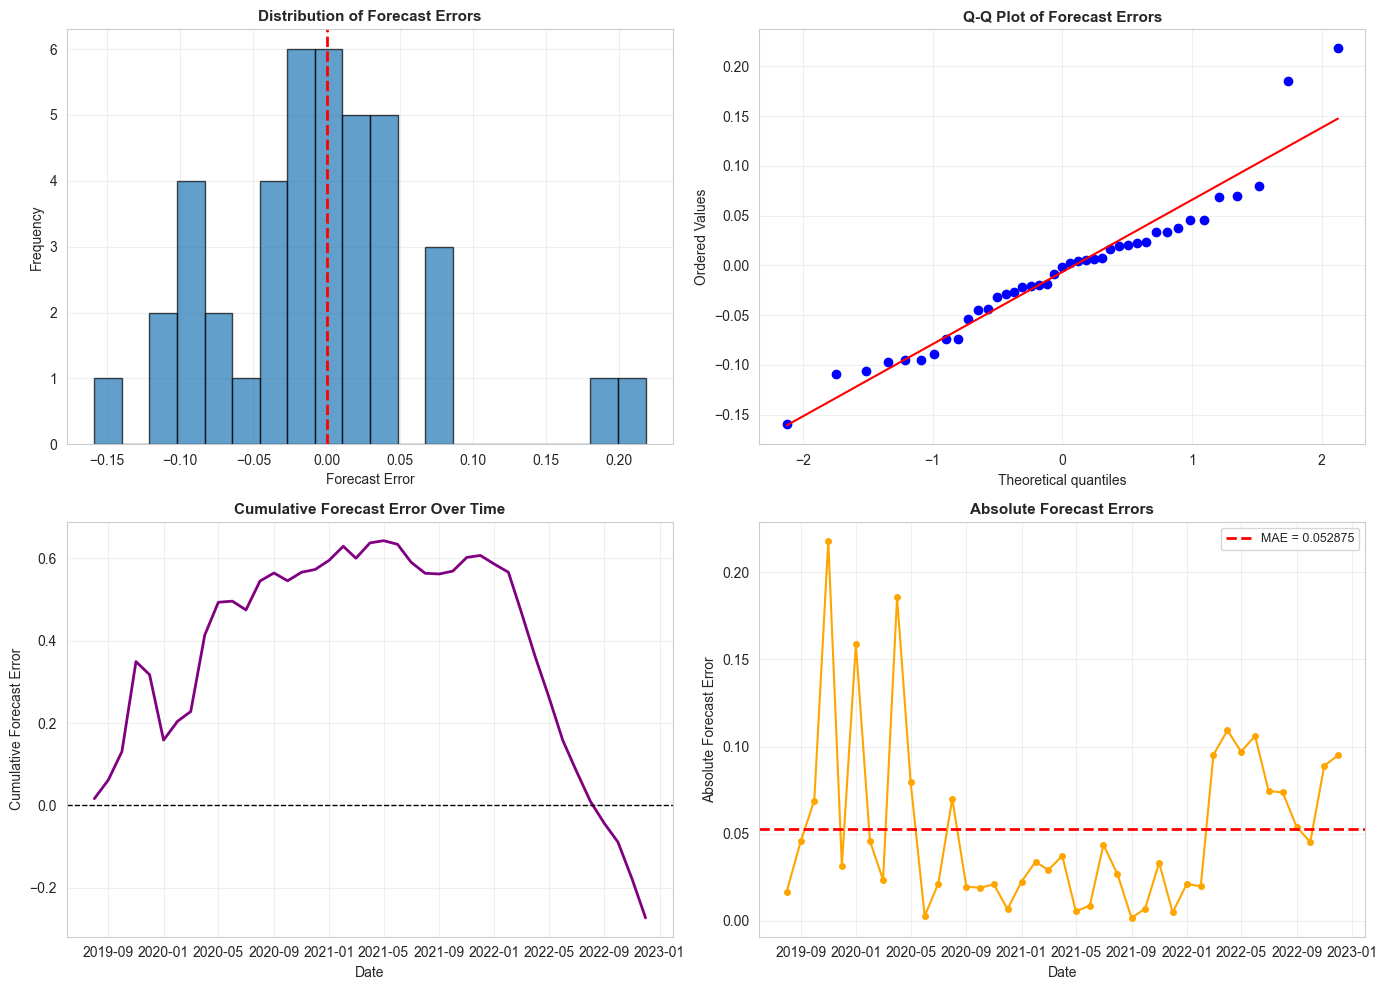

In [10]:
# Residual diagnostics plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residual histogram
ax1 = axes[0, 0]
ax1.hist(errors, bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Forecast Error', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_title('Distribution of Forecast Errors', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Residual Q-Q plot
from scipy import stats as sp_stats
ax2 = axes[0, 1]
sp_stats.probplot(errors, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot of Forecast Errors', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Cumulative forecast error
ax3 = axes[1, 0]
cumulative_error = errors.cumsum()
ax3.plot(cumulative_error.index, cumulative_error.values, linewidth=2, color='purple')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Date', fontsize=10)
ax3.set_ylabel('Cumulative Forecast Error', fontsize=10)
ax3.set_title('Cumulative Forecast Error Over Time', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Absolute errors over time
ax4 = axes[1, 1]
abs_errors = np.abs(errors)
ax4.plot(abs_errors.index, abs_errors.values, linewidth=1.5, color='orange', marker='o', markersize=4)
ax4.axhline(y=mae, color='red', linestyle='--', linewidth=2, label=f'MAE = {mae:.6f}')
ax4.set_xlabel('Date', fontsize=10)
ax4.set_ylabel('Absolute Forecast Error', fontsize=10)
ax4.set_title('Absolute Forecast Errors', fontsize=11, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary and Interpretation

In [11]:
print("\n" + "="*100)
print("ECM FORECAST EVALUATION SUMMARY")
print("="*100)

print("\n📋 MODEL SPECIFICATION")
print("-"*100)
print(f"Training period: {df_clean_train.index[0]} to {df_clean_train.index[-1]} ({n_train} obs)")
print(f"Test period: {df_clean_test.index[0]} to {df_clean_test.index[-1]} ({len(df_clean_test)} obs)")
print(f"\nLong-run relationship: BEEF = {alpha:.4f} + {beta:.4f} × POULTRY")
print(f"Error correction coefficient: φ = {phi:.6f}")

print("\n📊 FORECAST PERFORMANCE")
print("-"*100)
print(f"Out-of-sample R²: {r2:.4f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Directional accuracy: {directional_accuracy:.2f}%")

print("\n💡 INTERPRETATION")
print("-"*100)

if r2 > 0:
    print(f"✓ Positive out-of-sample R² ({r2:.4f}) indicates the ECM has predictive power")
else:
    print(f"⚠️ Negative out-of-sample R² ({r2:.4f}) suggests limited predictive power")

if directional_accuracy > 50:
    print(f"✓ Directional accuracy ({directional_accuracy:.1f}%) exceeds random chance (50%)")
else:
    print(f"⚠️ Directional accuracy ({directional_accuracy:.1f}%) does not exceed random chance")

improvement = ((naive_rmse - rmse) / naive_rmse * 100)
if improvement > 0:
    print(f"✓ ECM outperforms naive forecast by {improvement:.1f}% (RMSE reduction)")
else:
    print(f"⚠️ ECM does not outperform naive forecast (RMSE higher by {abs(improvement):.1f}%)")

print("\n🔍 NOTES")
print("-"*100)
print("• Forecasting monthly commodity price changes is inherently difficult")
print("• Low R² is common for short-term price forecasts due to market noise")
print("• ECM captures long-run equilibrium relationship, not short-term volatility")
print("• Directional accuracy may be more relevant than point forecast accuracy")

print("\n" + "="*100)
print("END OF FORECAST EVALUATION")
print("="*100)


ECM FORECAST EVALUATION SUMMARY

📋 MODEL SPECIFICATION
----------------------------------------------------------------------------------------------------
Training period: 2002-11-01 00:00:00 to 2019-06-01 00:00:00 (200 obs)
Test period: 2019-07-01 00:00:00 to 2022-12-01 00:00:00 (42 obs)

Long-run relationship: BEEF = 6.8242 + 1.5769 × POULTRY
Error correction coefficient: φ = -0.000610

📊 FORECAST PERFORMANCE
----------------------------------------------------------------------------------------------------
Out-of-sample R²: -0.7888
RMSE: 0.072266
MAE: 0.052875
Directional accuracy: 56.10%

💡 INTERPRETATION
----------------------------------------------------------------------------------------------------
⚠️ Negative out-of-sample R² (-0.7888) suggests limited predictive power
✓ Directional accuracy (56.1%) exceeds random chance (50%)
⚠️ ECM does not outperform naive forecast (RMSE higher by 33.7%)

🔍 NOTES
-------------------------------------------------------------------------